# **Presentación**

## Universidad Nacional de Rosario

### **Tecnicatura Universitaria en Inteligencia Artificial**

### IA42 - Procesameinto del Lenguaje Natural

---

**Fecha**: 02/11/2023

**Integrantes**:
- Ferrucci Constantino
- Giampaoli Fabio

**Docentes**:
- Juan Pablo Manson
- Alan Geary
- Andrea Cavallo
- Ariel D'Alessandro

---

## Resumen

En presente trabajo tiene como finalidad la resolución práctica de ejercicios propuestos por la asignatura `Procesamiento del Lenguaje Natural` con el fin de afianzar los contenidos teoricos prácticos brindados durante el cursado de las primeras tres unidades.

Los ejercicios son de naturaleza continua. Es decir, el desarrollo de un ejercicio requiere la resolcuión de los anteriores. Los mismos consisten principalmente en tareas de procesamiento de texto extraidos de fuentes de noticias de distintas categorias.

Durante el desarrollo del trabajo, se presentan soluciones y problematicas que requieren de soluciones con Web Scraping, depuración de texto, transformaciones vectoriales y entrenamiento y uso de modelos de lenguaje.

# **Entorno**

En este item se pretende generar e importar clases y funciones que seran de utilidad para el desarrollo de los ejercicios.

### Librerias

Para desarrollar las funcionalidades requeridas es necesario hacer uso de distintos paquetes y funciones que ofrece Python para procesar datos y lenguaje.

In [1]:
%%capture
!pip install sentence-transformers transformers
!pip install unidecode pattern
!pip install pyTelegramBotAPI
!python -m spacy download es_core_news_sm

In [2]:
# Web Scraping
import requests
from bs4 import BeautifulSoup

# Visualizaciones
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from IPython.display import clear_output
import plotly.express as px
import tqdm

# Procesamiento De Datos
import pandas as pd
import re
from random import choice

# Modelos De Lenguaje
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import spacy
import nltk
from sentence_transformers import SentenceTransformer, util
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers import T5Tokenizer, T5ForConditionalGeneration

# otros modelos
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA

# Depuracion De Texto
from nltk.corpus import stopwords
from pattern.es import singularize
import networkx as nx
import unidecode
from nltk.stem.snowball import SnowballStemmer

# Telegram Bot
import telebot

### Configuración inicial

Las siguientes líneas de código logran establecer configuraciones iniciales que seran de utilidad para el transcurso de todo el trabajo.

In [3]:
nltk.download('stopwords') # descarga de stopwords
spanish_stop_words = stopwords.words('spanish')  # Stopwords en español

pd.set_option('display.max_colwidth', None)  # Esto muestra el máximo de anchura de una columna de un dataframe
nlp = spacy.load('es_core_news_sm')  # Cargamos el modelo de tokenizacion en español

stemmer = SnowballStemmer('spanish')  # Definimos el stemmer en español

nltk.download('wordnet')  # Descargamos el lematizador
wn = nltk.WordNetLemmatizer()  # Instanciamos el lematizador

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


### Definición de clases

La siguiente clase se define con el fin facilitar la obtención y tratamiento de la información obtenida de las paginas web.

In [4]:
class Noticia:
  def __init__(self, titulo, texto, url):
    # define la estructura de las noticias
    self.titulo = titulo
    self.texto = texto
    self.url = url
    self.resumen = None

  def get_titulo(self):
    return self.titulo

  def get_texto(self):
    return self.texto

  def get_url(self):
    return self.url

  def __str__(self):
    # impresión amigable del objeto, muestra sus propiedades de forma ordenada
    noticia = f'{self.titulo} - ({self.url})\n\n{self.texto}'
    return noticia

  def set_resumen(self, resumen):
    self.resumen = resumen

La siguiente clase tiene la intención de generar metodos que permitan manipular el conjunto de noticias obtenidas para cada clase.

In [5]:
class Categoria:
  def __init__(self, categoria, url, id):
    # estructura de una categoria
    self.categoria = categoria
    self.url = url
    self.id = id
    self.noticias = []
    self.url_principal = url[: url.index('.com') + 4]

  def set_noticias(self, noticias):
    # almacenar las noticias en el objeto
    self.noticias = noticias

  def add_noticia(self, noticia):
    # añadir una nueva
    self.noticias.append(noticia)

  def get_noticias(self):
    return self.noticias

  def get_noticia(self, num_index):
    return self.noticias[num_index]

  def __str__(self):
    # formato de impresión ordenado de las noticias de una categoria
    if len(self.noticias) == 0:
      return 'No hay noticias cargadas.'
    texto = ''
    for i, noticia in enumerate(self.noticias):
      texto += f'{i + 1} - {noticia.get_titulo()} ({noticia.get_url()})\n'
    return texto

# **Ejercicios**

Contamos con cinco ejercicios en total. En cada desplegable de detalla en el uniciado de cada uno, su desarrollo y sus concluciones individuales.

Es importante considerar que los ejercicios son dependientes entre si, por lo que se recomienda entenderlos y replicarlos de forma ordenada.

### ***Primer ejercicio***  

---

Construir un dataset haciendo web scraping de páginas web de su elección.

- Definir 4 categorías de noticias/artículos.
- Para cada categoría, extraer los siguientes datos de 10 noticias diferentes:
- url (sitio web donde se publicó el artículo)
- título (título del artículo)
- texto (contenido del artículo)

Utilizando los datos obtenidos construya el dataset en formato csv.

---

#### Obtención de noticias

En la siguiente celda se inicializan las clases de categorias, cada una con sus atributos de Nombre, Url y Id.

Se elijieron las categorias mostradas debajo. De cada categoria se encuentra en internet la url de las paginas de disitntas fuentes que almacenan noticias correspondientes a cada categoria.

In [6]:
politica = Categoria('Politica', 'https://infobae.com/politica/', 0)
deporte = Categoria('Deporte', 'https://www.infobae.com/america/deportes/espn/', 1)
pelicula = Categoria('Pelicula', 'https://www.infobae.com/tag/peliculas/', 2)
tecnologia = Categoria('Tecnologia', 'https://www.infobae.com/tag/perfiles-tecno/', 3)

categorias = [politica, deporte, pelicula, tecnologia]

Se define una función externa cuya utilidad es la de hacer consultas a la web de una categoria dada.

A la consulta se le pasa por parametro la clase del elemnto que distingue a cada noticia en particular. Mediante investigación con las herramientas de desarrollador del motor de busqueda, se encuentra que cada fuente indentifica las noticias con una clase en particular.

Tambien es posible buscar mediante etiquetas los objetos que indentifican a cada noticia en la pagina web.



In [7]:
def find_noticia(categoria, class_=None, label=None):
    # toma la etiqueta o la clase de cada noticia
    args = {'class_': class_} if class_ else {'name': label}

    # abre la consulta a la web
    request = requests.get(categoria.url).text
    soup = BeautifulSoup(request, 'html')

    # se almacena la url de cada noticia particular
    urls_noticias = []

    for etiqueta in soup.find_all(**args)[:10]: # se filtran solo las primeras 10 noticias
        while etiqueta and etiqueta.name != 'a': # de cada noticia se recorre la estructura para encontrar su link
            etiqueta = etiqueta.parent
        urls_noticias.append(categoria.url_principal + etiqueta.get('href'))

    # se almacena de cada noticia su contenido y otras propiedades de las mismas en el objeto correspondiente
    noticias = []

    for url_noticia in urls_noticias:
        # consulta al url de la noticia particular
        request_noticia = requests.get(url_noticia).text
        soup_noticia = BeautifulSoup(request_noticia, 'html')
        # extraccion de atributos
        titulo = soup_noticia.find_all('h1')[0].text
        texto = '\n'.join([p.text for i, p in enumerate(soup_noticia.find_all('p')[1:]) if not p.text.startswith('Por ') or i != 0])
        noticia = Noticia(titulo, texto, url_noticia)
        # almacenamiento en memoria
        noticias.append(noticia)

    # almacenamiento en el objeto categoria
    categoria.set_noticias(noticias)
    return None

De esta manera, una vez que se conocen las clases que indetifican a cada noticia de la url general, podemos aplicar esta funcion para cargar en memoria las 10 noticias correspondientes a cada categoria.

Notar que en este caso la clase para la segunda categoria es distinta a las demas debido a que cambia la fuente de origen, por lo que la estructura de la pagina es distinta.

In [8]:
find_noticia(politica, 'feed-list-card-headline-lean')
find_noticia(deporte, 'story-card-hl')
find_noticia(pelicula, 'feed-list-card-headline-lean')
find_noticia(tecnologia, 'feed-list-card-headline-lean')

#### Visualización

En la siguiente celda desplegable se puede visualizar que se han cargado correctamente todas las noticas de cada categoria.

In [9]:
# Todas las noticias de cada categoria
for categoria in categorias:
  print(f'Noticias de {categoria.categoria} ({categoria.url})')
  print(categoria)

Noticias de Politica (https://infobae.com/politica/)
1 - Massa anunció un seguro, obra social, aportes jubilatorios y sitios de descanso para los trabajadores de apps de delivery (https://infobae.com/politica/2023/11/01/massa-anuncio-un-seguro-obra-social-aportes-jubilatorios-y-sitios-de-descanso-para-los-trabajadores-de-apps-de-delivery/)
2 - La CGT analiza organizar un acto de campaña con Sergio Massa en Santiago del Estero (https://infobae.com/politica/2023/10/31/la-cgt-analiza-organizar-un-acto-de-campana-con-sergio-massa-en-santiago-del-estero/)
3 - Alberto Weretilneck confirmó el apoyo del oficialismo de Río Negro a Sergio Massa y criticó con dureza a Javier Milei (https://infobae.com/politica/2023/10/31/alberto-weretilneck-confirmo-el-apoyo-del-oficialismo-de-rio-negro-a-sergio-massa-y-critico-con-dureza-a-javier-milei/)
4 - Un asesor de Milei criticó a Bullrich por sus dichos sobre la economía y luego se retractó (https://infobae.com/politica/2023/10/31/uno-de-los-asesores-econ

In [10]:
# ejemplo del contenido de una noticia
print(tecnologia.get_noticia(1))

Perfiles Tecno: Christoph Schell, vicepresidente ejecutivo de Intel no quiere una guerra con la IA - (https://www.infobae.com/tecno/2023/10/20/perfiles-tecno-christoph-schell-vicepresidente-ejecutivo-de-intel-no-quiere-una-guerra-con-la-ia/)

Los líderes de las compañías tecnológicas se enfrentan a varios retos ya que en sectores como este se exige innovación constante, políticas éticas relacionadas con temas como la privacidad de datos y el impacto social de sus productos, así como la atracción y retención de clientes.
Christoph Schell, vicepresidente ejecutivo y director comercial del Grupo de Ventas, Marketing y Comunicaciones de Intel Corporation, habló con Infobae y considera importante pensar las estrategias de mercadeo de manera más minimalista posible, para que los usuarios sean abiertos explorar nuevas tecnologías.
“¿Cómo se pone el silicio a trabajar?”, preguntó Schell, haciendo referencia a la forma más sencilla de cuestionarse cómo es que se debería presentar los productos 

La siguiente función tiene propocito de generar un historigrama de utilidad para dar una intuición de las longitudes de las noticias.

In [11]:
def plot_custom_histogram(data, bins=15, title="Histograma", x_label="Valores", y_label="Frecuencia", color='skyblue', edgecolor='black', alpha=0.7, grid=True, figsize=(14, 6)):
  plt.figure(figsize=figsize)
  plt.hist(data, bins=bins, color=color, edgecolor=edgecolor, alpha=alpha)
  plt.title(title, fontsize=16)
  plt.xlabel(x_label, fontsize=12)
  plt.ylabel(y_label, fontsize=12)

  if grid:
      plt.grid(True, linestyle='--', alpha=0.7)

  plt.show()

La siguiente función tiene proposito de extraer la longitud de cada noticia de cada categoria y almacenarla en una lista.

In [12]:
def extract_longitud_noticias(categorias):
  # valores = [len(noticia.texto) for noticia in categoria.get_noticias() for categoria in categorias]
  data = []
  for categoria in categorias:
    for noticia in categoria.get_noticias():
      data.append(len(noticia.texto)) # longitud de una noticia
  return data

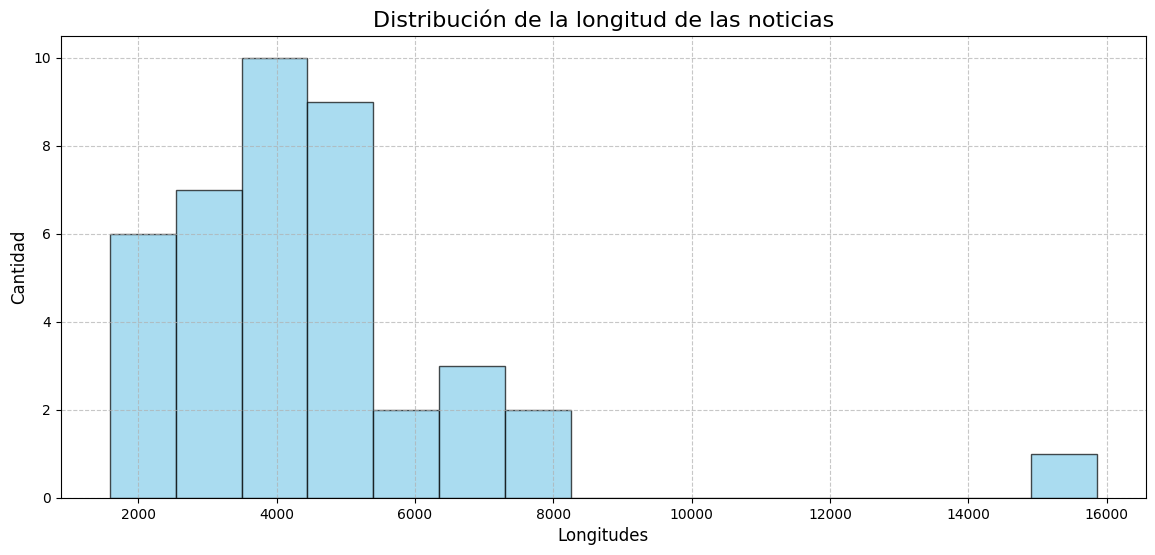

In [13]:
valores = extract_longitud_noticias(categorias) # metodo de obtencion de longitudes

plot_custom_histogram(valores, title="Distribución de la longitud de las noticias", x_label="Longitudes", y_label="Cantidad")

Este grafico sugiere que las longitudes de las noticias son mas comunes entres 2500 y 5000 caracteres.

#### Formato tabular

Para almacenar toda esta información en formato tabular haremos use de la siguiente función

In [14]:
def categorias_a_dataframe(categorias):
    # Crear una lista vacía para almacenar los datos
    data = []

    # Recorrer cada categoría
    for categoria in categorias:
        # Recorrer cada noticia en la categoría
        for noticia in categoria.get_noticias():
            # Añadir los datos de la noticia al DataFrame
            data.append([categoria.categoria, noticia.get_titulo(), noticia.get_url(), noticia.get_texto()])

    # Crear un DataFrame con los datos
    df = pd.DataFrame(data, columns=['Categoria', 'Titulo', 'URL', 'Texto'])

    return df

In [15]:
df_noticias = categorias_a_dataframe(categorias)
df_noticias.head(1)

Categoria  \
0  Politica   

                                                                                                                      Titulo  \
0  Massa anunció un seguro, obra social, aportes jubilatorios y sitios de descanso para los trabajadores de apps de delivery   

                                                                                                                                                                URL  \
0  https://infobae.com/politica/2023/11/01/massa-anuncio-un-seguro-obra-social-aportes-jubilatorios-y-sitios-de-descanso-para-los-trabajadores-de-apps-de-delivery/   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [16]:
df_noticias.to_csv('df_noticias.csv')

---

### ***Segundo ejercicio***

---

Utilizando los datos de título y categoría del dataset del ejercicio anterior, entrenar un
modelo de clasificación de noticias en categorías específicas

---

#### Dataset

Como es de interes que el modelo pueda pueda clasificar la categoria de un ritulo dado, nuestra variable objetivo para la clasificación seria 'Categoria'. Pero antes se normaliza el texto a formato minuscula.

In [17]:
# normalizar a formato miniscula
df_noticias['Titulo'] = df_noticias['Titulo'].str.lower()
df_noticias['Categoria'] = df_noticias['Categoria'].str.lower()

# separacion de variables
X = df_noticias['Titulo']
y = df_noticias['Categoria']

Separamos el dataset en datos de entrenamiento y validación. De esta forma, podremos entrenar el modelo de clasificación y luego obtener sus predicciones para validarlas.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Vectorización

Para que el modelo pueda interpretar los datos de este conjunto en su naturaleza textual, seria necesario llevar los datos a un espacio vectorial numerico.

En este caso se selecciona el vectorizador TF-IDF, ya que el mismo tinene la ventaja de que escala hacia abajo el impacto de las palabras que ocurren con mucha frecuencia en un corpus dado y que son, por lo tanto, menos informativas que las características que ocurren en una pequeña fracción del corpus de entrenamiento.

En este caso, al clisificar noticias basándose en sus títulos y categorías, TF-IDF es útil porque permitire determinar qué palabras son las más descriptivas para cada categoría.

In [19]:
vectorizer = TfidfVectorizer(stop_words=spanish_stop_words) # limpiamos los textos eliminando las stopwords

Primero se entrena el vectorizador solo con los datos de entrenamiento, y luego se transforman ambos conjuntos.

In [20]:
# X_vectorized = vectorizer.fit_transform(X)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

En el siguiente gráfico podemos visualizar en una espacio tridimensional la distribución de cada titulo en el espacio. Notar que se reduce la dimensionalidad del espacio usando Analisis de componentes principales con el fin de permitir la visualización.

In [21]:
# Crear el objeto PCA y ajustarlo a los datos
pca = PCA(n_components=3)
X_test_pca = pca.fit_transform(X_test_vectorized.toarray())
# X_pca = pca.fit_transform(X_vectorized.toarray())

# Crear un DataFrame con los datos transformados
df_pca = pd.DataFrame(data = X_test_pca, columns = ['PC1', 'PC2', 'PC3'])
df_pca['Titulo'] = df_noticias['Titulo'].str.slice(0, 10)  # recorta los titulos a 10 caracteres para no invadir el grafico

# Crear un gráfico de dispersión 3D interactivo
fig = px.scatter_3d(df_pca, x='PC1', y='PC2', z='PC3', text='Titulo')
fig.show()

#### Modelo

Se utiliza un modelo de regresión logistica debido a su capacidad de clasificacion multiclase.

In [22]:
model = LogisticRegression(max_iter=10000, solver='lbfgs', penalty='l2')

# entrenamiento con el conjunto apropiado
model.fit(X_train_vectorized, y_train)

LogisticRegression(max_iter=10000)

Ahora es posible predecir la categoria a la que pertenecen el conjunto de titulos reservados para validación, y obtener metricas de que preciso es el modelo a la hora de clasificar.

In [23]:
# hacemos predicciones de las categorias
y_pred_LR = model.predict(X_test_vectorized)

# veamos las predicciones
preds = pd.DataFrame()
preds['X_test'] = X_test
preds['y_pred_LR'] = y_pred_LR

display(preds)

,X_test,y_pred_LR
19,"un grave error defensivo, el cruce xavi-vinicius y el doblete consagratorio de bellingham: las perlitas del barcelona-real madrid",tecnologia
16,"con un doblete de haaland, el city venció 3-0 al united en el clásico de manchester",tecnologia
15,independiente empató 0-0 con arsenal y quedó como escolta de river en la zona a de la copa de la liga,tecnologia
26,paco plaza y el cine de terror español,pelicula
4,quiénes son los cuatro periodistas que moderarán el debate presidencial previo al balotaje,politica
12,eden hazard expresó otra vez su fanatismo por riquelme y reveló que hará si román lo llama para jugar en boca juniors,tecnologia
37,"la inteligencia artificial es compañera para la creatividad humana, no su competencia: fundador de canva",tecnologia
27,más adrenalina en “vértigo”: la angustiante película se convierte en franquicia con dos secuelas,pelicula


Notamos que en algunos registros clasifica incorrectamente, pero en general tiene buenos resultados. Veamos las metricas del modelo.

In [24]:
# este metodo retorna todas las metricas de utilidad para clasificación de cada clase
report_LR = classification_report(y_test, y_pred_LR, zero_division=1, output_dict=True)
df_report_LR = pd.DataFrame(report_LR).transpose()

print("\nReporte de clasificación Regresión Logística:")
display(df_report_LR)


Reporte de clasificación Regresión Logística:


,precision,recall,f1-score,support
deporte,1.0,0.00,0.000000,4.0
pelicula,1.0,1.00,1.000000,2.0
politica,1.0,1.00,1.000000,1.0
tecnologia,0.2,1.00,0.333333,1.0
accuracy,0.5,0.50,0.500000,0.5
macro avg,0.8,0.75,0.583333,8.0
weighted avg,0.9,0.50,0.416667,8.0


Notamos buenas metricas en general para el modelo. Aunque bien, este podria mejorar con un conjunto de datos mayor o con otras técnicas de vectorización o clasificación.

---

### ***Tercer ejercicio***

---

Para cada categoría, realizar las siguientes tareas:

- Procesar el texto mediante recursos de normalización y limpieza.
- Con el resultado anterior, realizar conteo de palabras y mostrar la importancia de las mismas mediante una nube de palabras.

Escribir un análisis general del resultado obtenido.

---

#### Procesamiento

Para la depuración del texto se definen las siguiente funciones para darle un formato estandarizado a cada texto de las noticias.

In [25]:
def preprocess_text(text):
    text = text.lower() # capitalización a minúsculas
    text = unidecode.unidecode(text) # eliminar acentos
    text = ''.join([c for c in text if c.isalnum() or c.isspace()]) # eliminar caracteres no alfanuméricos
    words = text.split() # dividir el texto por palabras individuales
    words = [word for word in words if word not in spanish_stop_words] # eliminar las palabras de parada del español
    # words = [singularize(palabra) for palabra in words] # volver a singular las palabras
    # words = [stemmer.stem(word) for word in words] # lematizar las palabras

    return ' '.join(words)

def extract_text_from_noticias(categorias):
    # Extrae el texto de las noticias para cada categoría
    noticias = {categoria.id: [noticia.get_texto() for noticia in categoria.get_noticias()] for categoria in categorias}
    return noticias

def extract_preprocessed_text_from_noticias(categorias):
    # Extrae y preprocesa el texto de las noticias para cada categoría
    noticias = {categoria.id: [preprocess_text(noticia.get_texto()) for noticia in categoria.get_noticias()] for categoria in categorias}
    return noticias

Por lo tanto se requeriere una unica llamada al objeto categoria para extraer todo el texto de cada notica de forma normalizada en una estrutura de datos.

In [26]:
noticias = extract_preprocessed_text_from_noticias(categorias)

#### Nube de palabras

Se define una función cuyo objetivo es iterar cada categoria de la estructura de datps con texto normalizado, y luego se vectorizan de forma que cada palabra pueda representarse con su frecuencia de aparación correspondiente a cada categoria.

In [27]:
def graficar_nube_palabras(noticias):
    for category, preprocessed_texts in noticias.items():

        # Crea una nube de palabras para la categoría
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(preprocessed_texts))

        # Muestra la nube de palabras de la categoría
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title(f'\n{df_noticias["Categoria"].unique()[category].upper()}')
        plt.show()

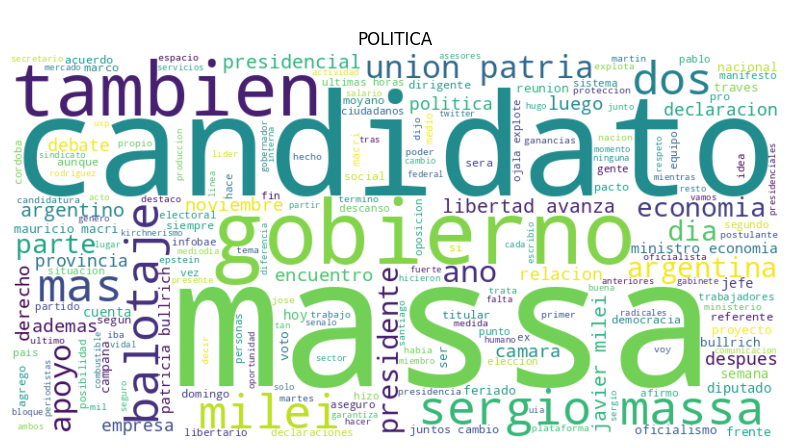

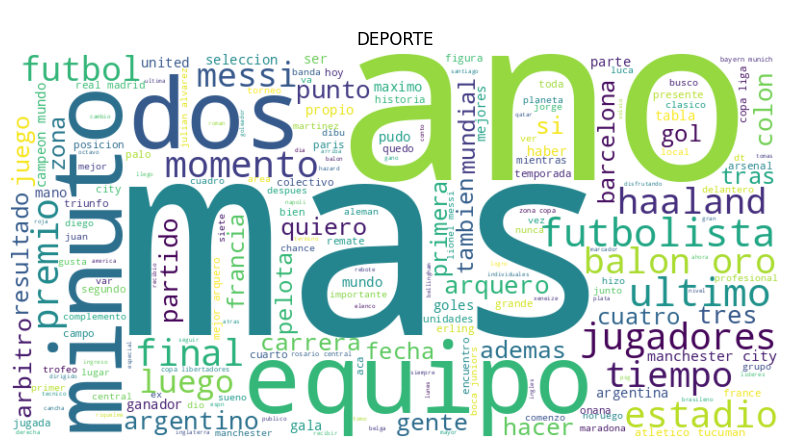

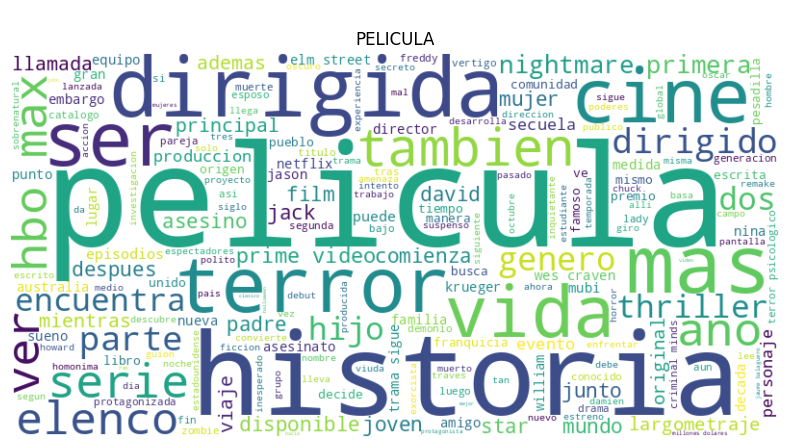

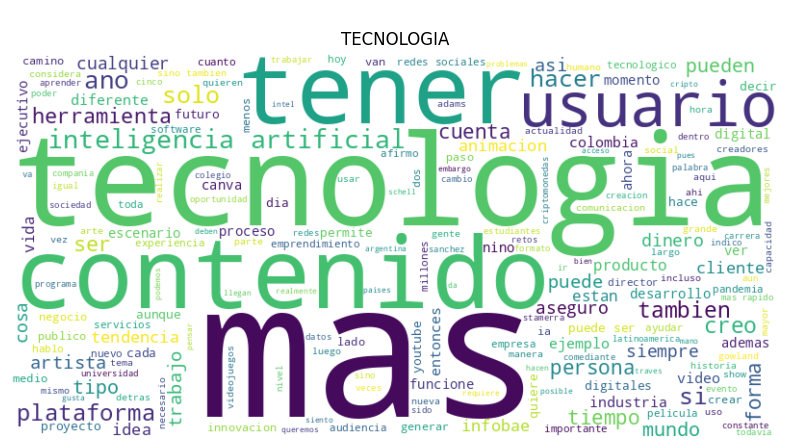

In [28]:
graficar_nube_palabras(noticias)

Vemos que aparecen para cada categoria palabras con mucha mas frecuencia que las demas. Pero que tambien aparacen palabras comunes a todos los textos.

La nube de palabras cambiara cada vez que se ejecute la funcion de extraer noticias de las paginas establecidas debido a su constante actualización. Es posible que dependiendo del conjunto de noticias, las palabras significativas de cada categoria podria variar.

Por ejemplo, para la categoria politica, las palabras Massa y Milei son altamente frecuentes debido a las fechas cercenas y contexto de elecciones presidenciales. Pero, el conjunto podria no contener palabras significativas que destaquen a la categoria mas alla de los nombres propios. Esto podria confundir a un modelo de clasificación con enfoque en medición de frecuencias.

---


### ***Cuarto ejercicio***


---

Use los modelos de embedding propuestos sobre el final de la Unidad 2 para evaluar la
similitud entre los títulos de las noticias de una de las categorías.
Reflexione sobre las limitaciones del modelo en base a los resultados obtenidos, en
contraposición a los resultados que hubiera esperado obtener.

---

#### Embedding

En este caso se utilizara el modelo Sentence-Bert para lograr obtener los embeddings de los titulos de cada noticia. Esto debido a que este modelo basado en la arquitectura BERT puede entender el significado semántico de las oraciones pueden compararse con facilidad.

In [29]:
# seleccion de modelo multilignue para procesar texto en español (y palabras ingles que suelen aparecer)
modelo = SentenceTransformer('distiluse-base-multilingual-cased-v1')

Se elige la categoria y aplicamos embedding a los titulos de las noticias de la misma.

In [30]:
noticias_tecnologia = [noticia.titulo for noticia in tecnologia.get_noticias()] # obtener noticias de deportes
embeddings = modelo.encode(noticias_tecnologia, convert_to_tensor=True)

#### Comparaciones

S-Bert se caracteriza debido a que el espacio de embeddings que genera puede ser medido mediante similud de coseno, que es una forma de medir la distancia entre dos elementos del mismo espacio de forma eficiente.

El modulo ofrece la utilidad de crear una matrix que representa mide cuán similares son entre sí las noticias en términos de su significado semántico, utilizando la métrica de similitud coseno.

In [31]:
puntuaciones_coseno = util.cos_sim(embeddings, embeddings)

La siguiente función tiene intención de generar un dataframe que muestre la similitud de coseno mas altas entre dos titulos de forma ordenada.

In [32]:
def get_similarity_cos_df(puntuaciones):
    # almacena los pares de titulos a comparar
    pares = []
    for i in range(len(puntuaciones)-1):
        for j in range(i+1, len(puntuaciones)):
            pares.append({'index': [i, j], 'score': puntuaciones[i][j]})

    # Ordenamos las puntuaciones en orden decreciente
    pares = sorted(pares, key=lambda x: x['score'], reverse=True)

    # Añadimos las filas a la tabla
    tabla = []

    for par in pares[0:10]:
        i, j = par['index']
        tabla.append([noticias_tecnologia[i], noticias_tecnologia[j], f"{par['score']:.4f}"])
    columnas = ['Titulo 1', 'Titulo 2', 'Simulitud']

    # transformacion a dataframe
    df = pd.DataFrame(tabla, columns=columnas)
    return df

In [33]:
df_simil_cos = get_similarity_cos_df(puntuaciones_coseno)
df_simil_cos.head()

,Titulo 1,Titulo 2,Simulitud
0,"Perfiles Tecno: Christoph Schell, vicepresidente ejecutivo de Intel no quiere una guerra con la IA","Shawn Krause de Pixar en Perfiles Tecno: no tengo miedo a la inteligencia artificial, es una herramienta",0.5402
1,"Shawn Krause de Pixar en Perfiles Tecno: no tengo miedo a la inteligencia artificial, es una herramienta","La inteligencia artificial es compañera para la creatividad humana, no su competencia: fundador de Canva",0.4689
2,"Perfiles Tecno: Christoph Schell, vicepresidente ejecutivo de Intel no quiere una guerra con la IA","La inteligencia artificial es compañera para la creatividad humana, no su competencia: fundador de Canva",0.4101
3,"La historia de Jhon, un ingeniero con discapacidad que creó un software para hablar y ser profesor","Cómo un comediante logró el éxito profesional con la tecnología, la historia de Iván Marín",0.3868
4,"Shawn Krause de Pixar en Perfiles Tecno: no tengo miedo a la inteligencia artificial, es una herramienta",Perfiles tecno | Cómo la inteligencia artificial ayuda a las empresas y la creación de contenido SEO,0.3810


In [34]:
noticias_tecnologia

['Cómo el mercado cripto en Latinoamérica avanza y cuál es su relación con la brecha digital',
 'Perfiles Tecno: Christoph Schell, vicepresidente ejecutivo de Intel no quiere una guerra con la IA',
 'Cómo triunfar en Youtube: Alejandro Gowland, líder de Creative Works de Google, reveló el secreto',
 'Así es como Movistar Arena ha modernizado Bogotá con tecnología en eventos y conciertos',
 'Shawn Krause de Pixar en Perfiles Tecno: no tengo miedo a la inteligencia artificial, es una herramienta',
 'Los trabajos con los que sueñan nuestros hijos: youtuber, gamer o influencer, estas son las razones',
 'La historia de Jhon, un ingeniero con discapacidad que creó un software para hablar y ser profesor',
 'La inteligencia artificial es compañera para la creatividad humana, no su competencia: fundador de Canva',
 'Perfiles tecno | Cómo la inteligencia artificial ayuda a las empresas y la creación de contenido SEO',
 'Cómo un comediante logró el éxito profesional con la tecnología, la historia

Los resultados no parecen tan errados para este conjunto de noticias en particular. Por ejemplo, las noticias que mencionan a la inteligencia artificial en el titulo es de esperar que tengan similutes mas altas debido al topico de la noticia.

Aunque bien podriamos haber esperado una similitud mas alta entre el titulo *'Cómo triunfar en Youtube: Alejandro Gowland, líder de Creative Works de Google, reveló el secreto'*  y el titulo *'Los trabajos con los que sueñan nuestros hijos: youtuber, gamer o influencer, estas son las razones'* debido a que contextualmente refieren al mismo topico de nuevas plataformas o formas de trabajo.

En casos como estos S-BERT puede estar sufriendo la limitación de que su pre-entrenamiento pudo no haber tenido sufiente datos de ejemplo para interpretar que titulos como estos pueden estar relacionados.

En cambio en el tópico de la inteligencia Artificial si encuentra relaciones, incluso cuando en un titulo utiliza la abrevación IA para referirce a la misma.

---

### ***Quinto ejercicio***

---

Escriba un programa interactivo que, según la categoría seleccionada por el usuario,
devuelva un resumen de las noticias incluidas en ella.
Justifique la elección del modelo usado para tal fin.

---

#### Abstración

Para esta consigna se utiliza un enfoque abstractivo para generar resumenes de las noticias.

La idea es utilizar un modelo generativo que consuma todas las noticas de una categoria, genera los tokes correspondientes a cada noticia y resume individuamente cada una con una longitud dada.

Las noticas resumidas se cargan en memoria, de forma que una una vez todas las noticias de las cada categoria ha sido resumida, se puedan acceder a ellas para generar un resumen de toda la categoria.

In [35]:
# selecion del modelo y tokenizador
tokenizer = AutoTokenizer.from_pretrained("csebuetnlp/mT5_multilingual_XLSum")
summarize_model = AutoModelForSeq2SeqLM.from_pretrained("csebuetnlp/mT5_multilingual_XLSum")

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:473: UserWarning:

The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.



La siguiente función tiene la intención de itererar todas las noticias de una categoria dada y resumirlas indivisuamente, con el fin de almacenarlas en memoria para accerderlas de forma rapida.

In [36]:
def summarize_category(model, tokenizer, category):
    summaries = []
    for noticia in category.get_noticias(): # itera cada noticia de la categoria
        if noticia.resumen: # valida si no tiene un resumen ya hecho
          continue

        titulo = noticia.titulo
        texto = noticia.texto
        inputs = tokenizer.encode("summarize: " + texto, return_tensors="pt", max_length=256, truncation=True) # tokeniza el texto de la noticia
        summary_ids = model.generate(inputs, max_length=100, min_length=25, length_penalty=2.0, num_beams=4, early_stopping=True) # genera un resumen de la misma
        resumen = tokenizer.decode(summary_ids[0], skip_special_tokens=True) # retorna a formato de lenguaje natural
        noticia.set_resumen(resumen)

Como el proceso de resumir toda una categoria resulta muy costoso en tiempo, se pretende con la siguiente celda realizar el resumen de las 40 noticias de una sola vez y cargarlas en memoria.

De esta forma, en el panel interactivo el usuario recibe una expereiencia mas fluida a la hora de consultar por un resumen.

Advertencia: La siguiente celda puede resultar muy costosa de ejecutar.

In [37]:
print('Resumiendo noticias...')

for category in tqdm.tqdm(categorias): # itereca cada categoria
  summarize_category(summarize_model, tokenizer, category) # resume cada categoria

print('\n¡Noticias resumidas!')

Resumiendo noticias...


100%|██████████| 4/4 [09:05<00:00, 136.27s/it]


¡Noticias resumidas!


#### Control interactivo

Se crea un bucle interactivo que facilite al usuario la ejecucion de un menu de seleccion de categorias con el fin de retornar el resumen de todas las noticias de la misma.

In [40]:
while True:
    print('Selecciona una categoria:\n1- Politica\n2- Deporte\n3- Pelicula\n4- Tecnologia\n9- Salir\n') # menú de seleccion
    category = None

    while True:
        category_num = input('>>> ')

        if category_num not in ["1", "2", "3", "4", "9"]: # opciones de seleccion
            print('La opcion es incorrecta')
            continue

        break

    if category_num == "9": # bandera de escae
        print('Programa finalizado')
        break

    category_num = int(category_num) - 1 # acceso a la categoria por indice
    category = categorias[category_num]
    print(f'Resumiendo las noticias de la categoria {df_noticias["Categoria"].unique()[category_num]}\n')

    summarize_category(summarize_model, tokenizer, category) # sumariza nuevamente por si hay noticias que no pasaron por la celda anterior
    for i, noticia in enumerate(category.get_noticias()):
      print(f'{i+1} - {noticia.titulo}\n{noticia.resumen}\n\n') # imprime el resumen de la noticia en items

    print('Selecciona una opcion:\n1- Elejir otra categoria\n2- Salir\n') # menu de continuacion
    option = None

    while True:
        option = input('>>> ')

        if option not in ["1", "2"]:
            print('La opcion es incorrecta')
            continue

        break

    if option == "2":
        print('Programa finalizado')
        break

    if option == "1":
        clear_output()
        continue

Selecciona una categoria:
1- Politica
2- Deporte
3- Pelicula
4- Tecnologia
9- Salir

>>> 9
Programa finalizado


### ***Opcional***


---

Investigar y programar un bot de Telegram que entregue un resumen de noticias del blog de su elección. Recomendamos el uso de pyTelegramBotAPI

---

#### Metodos

Para la construción de un chatbot de Telegram que resuma un conjunto de noticias de una categoria dada, se requiere la instalación de la libreria de Python 'telebot' que facilita metodos para conectar el programa a la plataforma de mensajeria Telegram.

La idea es que a partir del conjunto de resumenes de noticias de cada categoria que se han almacenado en momoria de este entorno, se puedan mostrar por pantalla con un menú de seleción similar al ejercicio previo.

Notar que es necesario que este entorno este activo y la celda posterior en ejecución.

In [39]:
bot = telebot.TeleBot("6471407350:AAGNyGqzMuYusqqPv0126rRc3d0OEJZaT9Q", parse_mode=None) # inicializa el bot con un token de autenticación

# cuando el usuario envía un comando que el bot no reconoce
def respuesta_defecto(message):
  bot.reply_to(message, "Por favor seleccione una opción ingresando el siguiente comando: /resumen 'opcion'\n-Politica\n-Deporte\n-Pelicula\n-Tecnologia")

# presentación al llamar cuando el bot recibe los comandos /start o /help
@bot.message_handler(commands=['start', 'help'])
def bienvenida(message):
  nombre = message.from_user.first_name
  bot.reply_to(message, f"¡Hola {nombre}!, soy un bot sobre noticias resumidas programado por Constantino Ferrucci y Fabio Giampaoli\nSeleccione una opción ingresando el siguiente comando: /resumen 'opcion'\n-Politica\n-Deporte\n-Pelicula\n-Tecnologia")

# menu de selecion al llamar cuando el bot recibe el comando /resumen
@bot.message_handler(commands=['resumen'])
def seleccion_noticia(message):

  msg = message.text.lower()
  msg_split = msg.split()

  if len(msg_split) < 2: # se deben recibir al menos dos argumentos
    respuesta_defecto(message)
    return

  category_name = msg_split[1]

  for category in categorias:
    if category.categoria.lower() == category_name: # filtra la categoria ingresada
      texto_respuesta = f'Mostrando noticias de la categoria {category.categoria}:\n\n'
      for i, noticia in enumerate(category.get_noticias()): # formatea el resumen de cada noticia de la categoria
        texto_respuesta += f'{i+1}- {noticia.titulo}\n\n{noticia.resumen}\n\n --- \n\n'

      # nuevo menu de continuacion
      texto_respuesta += "Para obtener otros resumenes recuerda seleccionar una opción ingresando el siguiente comando: /resumen 'opcion'\n-Politica\n-Deporte\n-Pelicula\n-Tecnologia"
      bot.reply_to(message, texto_respuesta)
      return

  else:
    respuesta_defecto(message)
    return

# ejecucion del bot en telegram
bot.infinity_polling()

2023-11-01 01:38:44,947 (__init__.py:966 MainThread) ERROR - TeleBot: "Infinity polling: polling exited"
ERROR:TeleBot:Infinity polling: polling exited
2023-11-01 01:38:44,951 (__init__.py:968 MainThread) ERROR - TeleBot: "Break infinity polling"
ERROR:TeleBot:Break infinity polling


Para comprobar el funcionamiento de este chatbot, se puede ingresar a Telegram y buscar el usuario **@LSNews_bot** e iniciar una conversación.

- El comando `/start` o `help` retornaran la presentación del bot.
- El comando `/resumen` retornara el menú de seleción de categorias.
- Para elegir una noticia del menú debe anteponer el comando `/resumen`. Por ejemplo: `/resumen Tecnologia`.

---

# **Concluciones**


A lo largo del proyecto se ha trabajado con un conjunto de noticias extraidos en el momento desde distintas paginas web que funcionan como blogs de noticias de una categoria en particular.

Mediante técnicas de web scraping se han extraido 10 noticias de 4 categorias y se han almacenado tanto en una estructura tabular de pandas, como en propiedades de clases de Python.

Las mismas han sido de utilidad para analizar y comprender las relaciones de las palabras, oraciones y textos con la categoria a la que pertenecen originalmente. Mediante un modelo de clasificación se ha logrado estimar la categoria a la que pertenece un titulo de noticia, y notamos un rendimiento decente que podria mejorar con conjuntos de datos mas grandes, debido a que titulos engañosos o con palabras con poco identificativas de una categoria pueden confundir al modelo.

Hemos visualizado la aparicion de palabras relevantes de cada categoria que podria ser clave para distiguirlas de sus clases, y comprendimos la similaridad que tienen los titulos en un espacio vectorial numerico. Notamos de ello que titulos que comparten palabras o conceptos en comun son muy cercanos entre si.

Por ultimo, se han utilizado modelos abstractivos de sumarizaciónn de texto, de manera que se ha logrado substraer de cada noticia los conceptos mas importantes de la misma generando palabras para darle sentido a estos conceptos a la hora de unificarlos en un mismo parrafo. Si bien un modelo como el utilizado puede mejorar con parametros mas apropiados, un conjunto de datos mas amplio, o un pre-entrenamiento o tamaño del modelo mas capaz, con un modelo 'pequeño' como el seleccionado puede realizar resumenes de las noticias de forma decente. Esto nos deja con un programa que se puede acceder desde Telegram que retorna un resumen de las 10 primeras noticias que se encuentran en las fuentes de las categorias ingresadas por pantalla.